# Computer Vision - AV-HuBERT Downstream Task Research

## Install Modules
This section installs necessary python packages for the other sections. Run it first.

In [1]:
!git clone https://github.com/facebookresearch/av_hubert.git

!cd avhubert
!git submodule init
!git submodule update
!pip install scipy
!pip install sentencepiece
!pip install python_speech_features
!pip install scikit-video

%cd fairseq
%pip install ./

Cloning into 'av_hubert'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 146 (delta 17), reused 25 (delta 12), pack-reused 111
Receiving objects: 100% (146/146), 4.65 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/bin/bash: line 0: cd: avhubert: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
[Errno 2] No such file or directory: 'fairseq'
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert
ERROR: Directory './' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


## Preprocess Dataset for AV-HuBERT

1. Install necessary tools for preprocessing

In [2]:
# !mkdir -p ./data/misc/
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !wget --content-disposition https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy -O ./data/misc/20words_mean_face.npy

2. Download a video from online

In [3]:
# !wget --content-disposition https://dl.fbaipublicfiles.com/avhubert/demo/avhubert_demo_video_8s.mp4 -O ./data/clip.mp4

3. Extract mouth ROI.

In [1]:
%cd ./av_hubert/avhubert/
# %cd ./avhubert

import dlib, cv2, os
import numpy as np
import skvideo
import skvideo.io
from tqdm import tqdm
from preparation.align_mouth import landmarks_interpolate, crop_patch, write_video_ffmpeg
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

def detect_landmark(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    coords = None
    for (_, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        coords = np.zeros((68, 2), dtype=np.int32)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def preprocess_video(input_video_path, output_video_path, face_predictor_path, mean_face_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(face_predictor_path)
  STD_SIZE = (256, 256)
  mean_face_landmarks = np.load(mean_face_path)
  stablePntsIDs = [33, 36, 39, 42, 45]
  videogen = skvideo.io.vread(input_video_path)
  frames = np.array([frame for frame in videogen])
  landmarks = []
  for frame in tqdm(frames):
      landmark = detect_landmark(frame, detector, predictor)
      landmarks.append(landmark)
  preprocessed_landmarks = landmarks_interpolate(landmarks)
  rois = crop_patch(input_video_path, preprocessed_landmarks, mean_face_landmarks, stablePntsIDs, STD_SIZE, 
                        window_margin=12, start_idx=48, stop_idx=68, crop_height=96, crop_width=96)
  write_video_ffmpeg(rois, output_video_path, "/usr/bin/ffmpeg")
  return

c:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert\av_hubert\avhubert


In [5]:
%pwd

'c:\\Users\\win8t\\OneDrive\\Desktop\\projects\\uni-all\\comp-vis-avhubert\\av_hubert\\avhubert'

In [7]:
%cd ..

c:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert


In [8]:
play_video('./data/clip.mp4', width=300)

In [8]:
face_predictor_path = "./data/misc/shape_predictor_68_face_landmarks.dat"
mean_face_path      = "./data/misc/20words_mean_face.npy"
origin_clip_path    = "./data/clip.mp4"
mouth_roi_path      = "./data/roi.mp4"
preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
play_video(mouth_roi_path)

RuntimeError: Unable to open ./data/misc/shape_predictor_68_face_landmarks.dat

### AV-HuBERT (Inference for Features)

In [12]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [10]:
import os
# %cd ./avhubert
import cv2
import tempfile
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def predict(video_path, ckpt_path, user_dir):
  num_frames = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
  data_dir = tempfile.mkdtemp()
  tsv_cont = ["/\n", f"test-0\t{video_path}\t{None}\t{num_frames}\t{int(16_000*num_frames/25)}\n"]
  label_cont = ["DUMMY\n"]
  with open(f"{data_dir}/test.tsv", "w") as fo:
    fo.write("".join(tsv_cont))
  with open(f"{data_dir}/test.wrd", "w") as fo:
    fo.write("".join(label_cont))
  fairseq.utils.import_user_module(Namespace(user_dir=user_dir))
  modalities = ["video"]
  gen_subset = "test"
  gen_cfg = GenerationConfig(beam=20)
  models, saved_cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  models = [model.eval().cuda() for model in models]
  saved_cfg.task.modalities = modalities
  saved_cfg.task.data = data_dir
  saved_cfg.task.label_dir = data_dir
  task = tasks.setup_task(saved_cfg.task)
  task.load_dataset(gen_subset, task_cfg=saved_cfg.task)
  generator = task.build_generator(models, gen_cfg)

  def decode_fn(x):
      dictionary = task.target_dictionary
      symbols_ignore = generator.symbols_to_strip_from_output
      symbols_ignore.add(dictionary.pad())
      return task.datasets[gen_subset].label_processors[0].decode(x, symbols_ignore)

  itr = task.get_batch_iterator(dataset=task.dataset(gen_subset)).next_epoch_itr(shuffle=False)
  sample = next(itr)
  sample = utils.move_to_cuda(sample)
  hypos = task.inference_step(generator, models, sample)
  ref = decode_fn(sample['target'][0].int().cpu())
  hypo = hypos[0][0]['tokens'].int().cpu()
  hypo = decode_fn(hypo)
  return hypo

# Linux
# mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
mouth_roi_path = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4"
ckpt_path      = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/base_vox_433h.pt"
#mouth_roi_path = "./data/roi.mp4"
#ckpt_path = "./data/.mp4"
user_dir       = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert"
# mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
#mouth_roi_path = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/data/roi.mp4"
#ckpt_path      = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/data/base_vox_433h.pt"
#mouth_roi_path = "./data/roi.mp4"
#ckpt_path = "./data/.mp4"
#user_dir       = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/avhubert"
hypo = predict(mouth_roi_path, ckpt_path, user_dir)
HTML(f"""
  <h3>
    Prediction - {hypo}
  </h3>
  """)

ConfigKeyError: Key 'input_modality' not in 'AVHubertPretrainingConfig'
    full_key: input_modality
    object_type=AVHubertPretrainingConfig

### Extract Visual Features

Shape of for visual features is [frames, 768], where 768 is presumably the output of the AV-HuBERT Transformer Encoder module for each frame.

In [14]:
%cd /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
import cv2
import tempfile
import torch
import utils as avhubert_utils
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from IPython.display import HTML

def extract_visual_feature(video_path, ckpt_path, user_dir, is_finetune_ckpt=False):
  utils.import_user_module(Namespace(user_dir=user_dir))
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  transform = avhubert_utils.Compose([
      avhubert_utils.Normalize(0.0, 255.0),
      avhubert_utils.CenterCrop((task.cfg.image_crop_size, task.cfg.image_crop_size)),
      avhubert_utils.Normalize(task.cfg.image_mean, task.cfg.image_std)])
  frames = avhubert_utils.load_video(video_path)
  print(f"Load video {video_path}: shape {frames.shape}")
  frames = transform(frames)
  print(f"Center crop video to: {frames.shape}")
  frames = torch.FloatTensor(frames).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
  model = models[0]
  if hasattr(models[0], 'decoder'):
    print(f"Checkpoint: fine-tuned")
    model = models[0].encoder.w2v_model
  else:
    print(f"Checkpoint: pre-trained w/o fine-tuning")
  model.cuda()
  model.eval()
  with torch.no_grad():
    # Specify output_layer if you want to extract feature of an intermediate layer
    feature, _ = model.extract_finetune(source={'video': frames, 'audio': None}, padding_mask=None, output_layer=None)
    print(f"Video feature shape: {feature.shape}")
    feature = feature.squeeze(dim=0)
  print(f"Video feature shape: {feature.shape}")
  return feature

mouth_roi_path = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4"
ckpt_path      = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/base_vox_433h.pt"
# user_dir = "/content/av_hubert/avhubert"
user_dir       = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert"
feature = extract_visual_feature(mouth_roi_path, ckpt_path, user_dir)

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4: shape (241, 96, 96)
Center crop video to: (241, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 241, 768])
Video feature shape: torch.Size([241, 768])


#### Save Visual Features

In [27]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [28]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [29]:
torch.save(feature, "./dataset/wsDmwoOrpR8/The False Appeal of Communism.pt")

## Dataset

In [13]:
def group_adjacent_duplicates(lst):
    result = []
    for item in lst:
        if len(result) == 0 or item != result[-1]:
            result.append(item)
    return result

### Dataset Loader

In [3]:
import torch

import numpy as np
import json
# import stable_whisper
import ffmpeg

import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

from torch.utils.data import Dataset
from typing import TypedDict, List
from cv2 import Mat

# from ultralytics.yolo.data.dataloaders.stream_loaders import LoadImages

from lib import *


class LipSpeechMedia(TypedDict):
    """Class definition for single dataset item."""
    title:         str
    audio_raw:     np.ndarray
    audio_feats:   np.ndarray
    frames_raw:    np.ndarray
    frames_lm:     np.ndarray
    frames_bboxes: np.ndarray
    phonemes:      np.ndarray
    av_hubert:     np.ndarray


class LipSpeechDataset(Dataset):
    """Lip-to-speech Dataset."""
    def __init__(self,
                 metadata: str,
                 dataset_dir: Path,
                 phoneme_dir: Path,
                 phoneme_dict_path: Path = Path("./phoneme_dict.txt"),
                 whisper_model: str = "base",
                 device: str = "cpu") -> Dataset:
        """Load the dataset using the metadata *.json file."""
        with open(metadata) as f:
            obj   = json.loads(f.read())
            train = obj["train"]
            self.data = train
        self.dataset_dir   = Path(dataset_dir)

        """
        # OpenAI Whisper and Facial Landmark Model
        self.whisper_model = stable_whisper.load_model(whisper_model)
        torchlm.runtime.bind(faceboxesv2(device=device))
        torchlm.runtime.bind(
        pipnet(backbone="resnet18", pretrained=True,  
                num_nb=10, num_lms=98, net_stride=32, input_size=256,
                meanface_type="wflw", map_location=device, checkpoint=None))
        """

        
        # Phonemes
        phoneme_dict = load_phoneme_dict(phoneme_dict_path)
        phoneme_dict = [phone.lower() for phone in phoneme_dict]
        phoneme_dict[0] = "sil"
        for sil_tok in ['sp', 'spn']: # silence tokens
            if sil_tok in phoneme_dict:
                phoneme_dict.remove(sil_tok)
        for i in range(len(phoneme_dict)):
            if phoneme_dict[i][-1] in string.digits:
                phoneme_dict[i] = phoneme_dict[i][:-1]
        phoneme_dict = list(dict.fromkeys(phoneme_dict))
        self.phoneme_dict = phoneme_dict

        self.phoneme_dir  = phoneme_dir
        

    def __len__(self) -> int:
        """Return the number of media files in the dataset."""
        return len(self.data)
    
    def __getitem__(self, i) -> LipSpeechMedia:
        """Get the `n`th item in the dataset."""

        # Get media details
        media  = self.data[i]
        title  = media["title"]
        url    = media["url"]
        vid_id = extract_video_id(url)

        # Check if it has been downloaded
        vid_fname  = f"{vid_id}"
        vid_exists = check_existing(vid_fname, self.dataset_dir)
        vid_dir    = Path(self.dataset_dir) / vid_fname
        vid_path   = str(vid_dir / f"{title}.mp4")
        aud_path   = str(vid_dir / f"{title}.mp3")
        srt_path   = str(vid_dir / f"{title}.srt")
        raw_path   = str(vid_dir / f"{title}.json")
        grd_path   = str(vid_dir / f"{title}.TextGrid")
        lm_path    = str(vid_dir / f"{title}.pkl")
        av_path    = str(vid_dir / f"{title}.pt")
        if not vid_exists:
            youtube_download(url, vid_dir)

        """
        # Get captions using Whisper, if not existing
        if not os.path.exists(raw_path):
            result = self.whisper_model.transcribe(vid_path)
            result.to_srt_vtt(srt_path)
            result.save_as_json(raw_path)
        """

        # Extract MP3 from MP4 for audio features
        print("aud_path:", aud_path)
        if not os.path.exists(aud_path):
            input_stream  = ffmpeg.input(vid_path)
            audio_stream  = input_stream.audio
            output_stream = ffmpeg.output(audio_stream, aud_path)
            ffmpeg.run(output_stream)

        # Load audio
        audio_raw   = load_audio(aud_path)
        audio_feats = get_audio_feats(
            audio_raw,
            hop_length=667,
            win_length=1_024,
            filter_length=1_024) # Match Video

        # Load video frames
        """
        images = LoadImages(
            vid_path,
            imgsz=640,
            stride=1,
            vid_stride=1).__iter__()
        """

        """
        # Get Facial Landmarks and BBoxes from Frames
        frames = []
        bboxes = []
        lm_s   = []
        while True:
            try:
                _, _, im0, _, _ = next(images)
                landmarks, bboxe_s = torchlm.runtime.forward(im0)
                frames.append(im0)
                bboxes.append(bboxe_s)
                lm_s.append(landmarks)
            except StopIteration:
                break
        frames = np.stack(frames, axis=0)
        lm_s   = np.concatenate(lm_s, axis=0)
        bboxes =  np.concatenate(bboxes, axis=0)
        """

        """
        # Get Phonemes for Audio
        punctuations = string.punctuation
        translator = str.maketrans('', '', punctuations)
        w_words, w_starts, w_ends = [], [], []
        with open(raw_path) as f:
            raw_srt  = json.loads(f.read())
            segments = raw_srt["segments"]
            for seg in segments:
                words = seg["words"]
                for word in words:
                    # Normalise word
                    w_word  = word["word"].strip()
                    w_word  = w_word.strip()
                    w_word  = w_word.translate(translator)
                    w_word  = w_word.lower()

                    w_start = word["start"]
                    w_end   = word["end"]


                    if w_start == w_end:
                        w_start -= 0.01

                    w_words.append(w_word)
                    w_starts.append(w_start)
                    w_ends.append(w_end)
        word_alignments = pd.DataFrame({
            "word": w_words,
            "start": w_starts,
            "end": w_ends})
        textgrid = gen_textgrid(word_alignments)
        with open(grd_path, "w") as f:
            f.write(textgrid)
        """

        # Load Phonemes for Audio
        phonemes = load_phonemes(
            grd_path,
            audio_feats,
            self.phoneme_dict,
            temporal_scale=24)
        
        # Load AV-HuBERT Features
        av_hubert = torch.load(av_path)

        # Data
        out = {
            "title":         media["title"],
            "audio_raw":     audio_raw,
            "audio_feats":   audio_feats,
            #'"frames_raw":    frames,
            #"frames_lm":     lm_s,
            #"frames_bboxes": bboxes,
            "phonemes":      phonemes,
            "av_hubert":     av_hubert
        }

        return out

### Dataset Temporal Alignment (Check)

In [337]:
%pwd

'C:\\Users\\win8t\\OneDrive\\Desktop\\projects\\uni-all\\comp-vis-avhubert'

In [338]:
%cd ../..

C:\Users\win8t\OneDrive\Desktop\projects


In [339]:
%cd "C:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert"

C:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert


In [4]:
dataset = LipSpeechDataset(
    metadata=Path("dataset.json"),
    dataset_dir=Path("./dataset"),
    phoneme_dir=Path("./phonemes"),
    device="cuda")

In [5]:
dataset[0].keys()

aud_path: dataset\wsDmwoOrpR8\The False Appeal of Communism.mp3


dict_keys(['title', 'audio_raw', 'audio_feats', 'phonemes', 'av_hubert'])

#### Compare Shapes

In [6]:
dataset[0]["audio_feats"].shape, dataset[0]["phonemes"].shape, dataset[0]["av_hubert"].shape

aud_path: dataset\wsDmwoOrpR8\The False Appeal of Communism.mp3
aud_path: dataset\wsDmwoOrpR8\The False Appeal of Communism.mp3
aud_path: dataset\wsDmwoOrpR8\The False Appeal of Communism.mp3


((239, 128), (239,), torch.Size([241, 768]))

## Data Analysis

### Phoneme Analysis

#### Load Phonemes

In [14]:
data        = dataset[0]

aud_path: dataset\wsDmwoOrpR8\The False Appeal of Communism.mp3


In [15]:
phonemes_df = pd.DataFrame({
    "phoneme": [dataset.phoneme_dict[p] for p in data["phonemes"]]
})

#### Value Counts

In [16]:
phonemes_df

,phoneme
0,dh
1,dh
2,ih
3,ih
4,z
...,...
234,ae
235,ae
236,ae
237,ae


In [17]:
counts = phonemes_df.value_counts()

In [18]:
counts

phoneme
n          31
sil        22
s          20
ih         14
w          14
dh         12
ae         12
iy         12
m          11
aa          9
er          8
l           7
t           6
k           6
ey          6
th          6
d           5
ah          5
p           5
f           5
z           4
eh          4
b           3
sh          3
r           3
ao          2
v           1
ng          1
y           1
g           1
dtype: int64

In [19]:
counts.sum()

239

In [20]:
ph_s = [v[0] for v in phonemes_df.values]
ph_s = group_adjacent_duplicates(ph_s)
print(ph_s)

['dh', 'ih', 'z', 'w', 'n', 'th', 'ih', 'z', 'dh', 'ah', 't', 'd', 'ih', 's', 't', 'ih', 'ng', 'g', 'w', 't', 'k', 'aa', 'm', 'y', 'ah', 'ih', 'ah', 'f', 'er', 'm', 'sil', 'l', 'eh', 't', 's', 'ey', 'm', 'ey', 'd', 'ih', 't', 'iy', 'v', 'n', 'm', 'ey', 'b', 'iy', 'm', 'ao', 'r', 'p', 'er', 'n', 'ih', 'sh', 's', 'n', 'aa', 't', 'z', 'b', 'ey', 's', 'k', 'l', 'iy', 's', 'eh', 'd', 'dh', 'ah', 'w', 'er', 'l', 'd', 'dh', 'ae', 's', 'f', 'er', 'dh', 'iy', 'aa', 'r', 'iy', 'n', 'ae']


#### Order-Frequency Plot

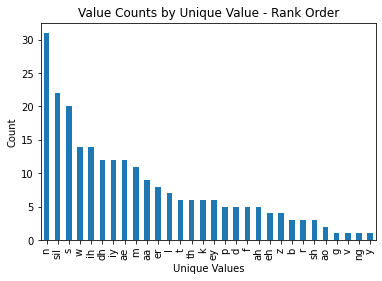

In [21]:
import matplotlib.pyplot as plt

# get the value counts and sort them in descending order
counts = phonemes_df['phoneme'].value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('Value Counts by Unique Value - Rank Order')

# display the plot
plt.show()

#### Analyse Original Predicted Phonemes

In [22]:
textgrid_fname = "./dataset/wsDmwoOrpR8/The False Appeal of Communism.TextGrid"
tg = TextGrid(textgrid_fname)

In [23]:
phones = tg["phones"]

In [24]:
phones

[<Interval text="" xmin=0.0 xmax=0.04>,
 <Interval text="DH" xmin=0.04 xmax=0.09>,
 <Interval text="IH1" xmin=0.09 xmax=0.13>,
 <Interval text="S" xmin=0.13 xmax=0.16>,
 <Interval text="IH0" xmin=0.16 xmax=0.19>,
 <Interval text="Z" xmin=0.19 xmax=0.25>,
 <Interval text="W" xmin=0.25 xmax=0.42>,
 <Interval text="AH1" xmin=0.42 xmax=0.45>,
 <Interval text="N" xmin=0.45 xmax=0.48>,
 <Interval text="TH" xmin=0.48 xmax=0.74>,
 <Interval text="IH1" xmin=0.74 xmax=0.8>,
 <Interval text="NG" xmin=0.8 xmax=0.81>,
 <Interval text="Z" xmin=0.81 xmax=0.84>,
 <Interval text="DH" xmin=0.84 xmax=0.97>,
 <Interval text="AH0" xmin=0.97 xmax=1.01>,
 <Interval text="T" xmin=1.01 xmax=1.06>,
 <Interval text="D" xmin=1.06 xmax=1.13>,
 <Interval text="IH0" xmin=1.13 xmax=1.19>,
 <Interval text="S" xmin=1.19 xmax=1.26>,
 <Interval text="T" xmin=1.26 xmax=1.32>,
 <Interval text="IH1" xmin=1.32 xmax=1.4>,
 <Interval text="NG" xmin=1.4 xmax=1.45>,
 <Interval text="G" xmin=1.45 xmax=1.48>,
 <Interval text="W" x

In [25]:
xmax  = np.array([p.xmax for p in phones])
xmin  = np.array([p.xmin for p in phones])
ph_s  = [p.text for p in phones]
ph_df = pd.DataFrame({"xmax": xmax, "xmin": xmin, "text": ph_s})

In [26]:
ph_df["duration"] = xmax - xmin

In [27]:
ph_df

,xmax,xmin,text,duration
0,0.04,0.00,,0.04
1,0.09,0.04,DH,0.05
2,0.13,0.09,IH1,0.04
3,0.16,0.13,S,0.03
4,0.19,0.16,IH0,0.03
...,...,...,...,...
102,9.55,9.48,IY0,0.07
103,9.58,9.55,AH0,0.03
104,9.59,9.58,N,0.01
105,9.62,9.59,Z,0.03


### Visualise Mel Spectrogram

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_mel_spectrograms(pred, text):
    fig, ax = plt.subplots(1) # nrows=1, ncols=2)

    # ax[0].set_title(f"Mel Spectogram (Predicted)")
    pred = np.swapaxes(pred, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    ax.set_title(text)
    
    return fig, ax

[]

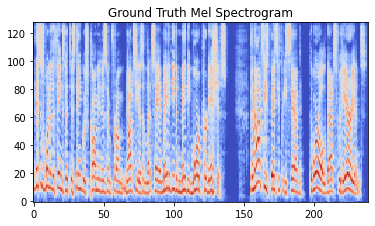

In [29]:
audio_feats = data["audio_feats"]
fig, ax = plot_mel_spectrograms(audio_feats, "Ground Truth Mel Spectrogram")
plt.plot()

## Model

#### LSTM

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
"""
class LipToVoiceModel(nn.Module):
    def __init__(self, input_dim, out_dim, num_layers, hidden_dim=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x, _ = self.lstm(x)
        x = self.fc1(x)
        # x = F.softmax(x, dim=-1)
        return x
"""

class LipToVoiceModel(nn.Module):
    def __init__(self, input_dim, out_dim, num_layers, hidden_dim=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, out_dim)
    
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x, _ = self.lstm(x)
        x = self.fc1(x)
        # x = F.softmax(x, dim=-1)
        return x

### Transformer

In [31]:
import torch.nn as nn

from lib.transformer import TransformerEncoderLayer

class LipToVoiceTransformerModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

### Linear Projection (Just for Phoneme Classification)

In [32]:
import torch.nn as nn

class LipToPhoneModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding"""
    def __init__(self, ins, hidden, outs, dropout=0.5):
        super(LipToPhoneModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

## Trainset and Testset

### All Possible Data

In [33]:
avhubert_feats = data["av_hubert"]
phonemes       = data["phonemes"]
audio_feats    = data["audio_feats"]
avhubert_feats.shape, phonemes.shape, audio_feats.shape

(torch.Size([241, 768]), (239,), (239, 128))

In [34]:
data["phonemes"].shape

(239,)

### Define Input, Output

In [35]:
device = "cuda"

In [75]:
x_s = avhubert_feats
y_s = phonemes
# y_s = audio_feats

In [76]:
x_s.shape, y_s.shape

(torch.Size([241, 768]), (239,))

In [77]:
x_s.dtype

torch.float32

In [78]:
import torch
# CUDA_LAUNCH_BLOCKING=1
x_s = torch.tensor(x_s, dtype=torch.float).to(device)
# y_s = torch.tensor(y_s, dtype=torch.float).to("cuda")
y_s = torch.tensor(y_s, dtype=torch.long).to(device)

C:\Users\win8t\AppData\Local\Temp/ipykernel_9924/763947734.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_s = torch.tensor(x_s, dtype=torch.float).to(device)


In [79]:
# (seq_len, 98, 2) => (seq_len, 196)
x_s = x_s.view(x_s.shape[0], -1)

In [80]:
# Verify `x_s`` and `y_s` shape
x_s.shape, y_s.shape

(torch.Size([241, 768]), torch.Size([239]))

In [81]:
dataset_ratio = 0.8
dataset_size  = min(x_s.shape[0], y_s.shape[0])
print(dataset_size)

239


In [82]:
x_s = x_s[0:dataset_size, :]

In [83]:
train_x_s = x_s[0:int(dataset_size * dataset_ratio), :]
test_x_s  = x_s[int(dataset_size * dataset_ratio):,  :]

In [84]:
y_s = y_s[0:dataset_size]

In [85]:
train_y_s = y_s[0:int(dataset_size * dataset_ratio)]
test_y_s  = y_s[int(dataset_size * dataset_ratio):]

In [86]:
x_s.shape, y_s.shape, train_x_s.shape, train_y_s.shape, test_x_s.shape, test_y_s.shape

(torch.Size([239, 768]),
 torch.Size([239]),
 torch.Size([191, 768]),
 torch.Size([191]),
 torch.Size([48, 768]),
 torch.Size([48]))

In [87]:
y_s.shape

torch.Size([239])

In [88]:
print(group_adjacent_duplicates(get_phone_list(y_s)))

['dh', 'ih', 'z', 'w', 'n', 'th', 'ih', 'z', 'dh', 'ah', 't', 'd', 'ih', 's', 't', 'ih', 'ng', 'g', 'w', 't', 'k', 'aa', 'm', 'y', 'ah', 'ih', 'ah', 'f', 'er', 'm', 'sil', 'l', 'eh', 't', 's', 'ey', 'm', 'ey', 'd', 'ih', 't', 'iy', 'v', 'n', 'm', 'ey', 'b', 'iy', 'm', 'ao', 'r', 'p', 'er', 'n', 'ih', 'sh', 's', 'n', 'aa', 't', 'z', 'b', 'ey', 's', 'k', 'l', 'iy', 's', 'eh', 'd', 'dh', 'ah', 'w', 'er', 'l', 'd', 'dh', 'ae', 's', 'f', 'er', 'dh', 'iy', 'aa', 'r', 'iy', 'n', 'ae']


### BatchDim for Seq Models

In [54]:
# x_s = x_s.unsqueeze(0)
# y_s = y_s.unsqueeze(0)

In [55]:
print("FINAL SHAPES:")
x_s.shape, y_s.shape

FINAL SHAPES:


(torch.Size([239, 768]), torch.Size([239]))

In [56]:
y_s.shape[-1]

239

## Train (Overfit) - Phone

In [57]:
def get_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    return d

In [58]:
def print_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    print(d)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 239
['aw', 'v', 'aw', 'aw', 'ay', 'z', 'd', 'd', 'd', 'd', 'z', 'z', 'aa', 'aw', 'k', 'aw', 'k', 'k', 'ow', 'aw', 's', 's', 'aw', 'th', 'b', 'ah', 'b', 'aa', 'b', 'b', 'b', 'b', 'ow', 'hh', 'z', 'p', 'z', 'z', 'er', 'er', 'er', 'er', 'z', 's', 'z', 'v', 'v', 'aw', 'aw', 's', 's', 'eh', 'eh', 'aw', 'ae', 'v', 'm', 'ng', 'ng', 'aa', 'aw', 'aw', 'ae', 'ae', 'zh', 'zh', 'zh', 'b', 'b', 'jh', 'jh', 'm', 'r', 'aw', 's', 's', 'eh', 'd', 'd', 'd', 'b', 'b', 'k', 'er', 'er', 'er', 'b', 'b', 'z', 'z', 'm', 'ae', 'aw', 'aw', 'ow', 'z', 'er', 'w', 'w', 'w', 'd', 'z', 'th', 'z', 'z', 'z', 'aw', 'w', 'er', 'er', 'aw', 'w', 'w', 'm', 'm', 'd', 'er', 'd', 'n', 'aw', 'aw', 'aw', 'aw', 'w', 'w', 'w', 'w', 'er', 't', 't', 'p', 'p', 'hh', 'er', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'v', 'z', 'aw', 'd', 'd', 'zh', 'zh', 'd', 'd', 'sil', 'k', 'k', 'b', 'oy', 'aw', 'aw', 'aw', 'aw',

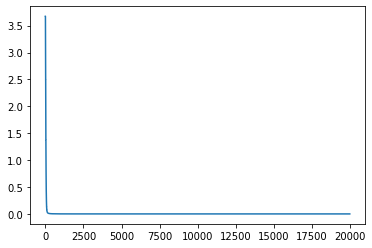

In [59]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    512,
    len(dataset.phoneme_dict)).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

## Train (Generalise) - Phone

device: cuda
train_x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 191
['eh', 'd', 'aw', 'aw', 'aw', 'aw', 'uw', 'uw', 'uw', 'uw', 'uw', 'zh', 'aw', 'eh', 'aw', 'ch', 'eh', 'r', 'eh', 'eh', 'eh', 'dh', 'hh', 'hh', 'hh', 'hh', 'oy', 'w', 'w', 'uh', 'uh', 'uh', 'z', 'z', 'er', 'er', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'aw', 'aw', 'aw', 'oy', 'oy']
['ah', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'er', 'er', 'er', 'l', 'd', 'dh', 'dh', 'dh', 'dh', 'ae', 'ae', 'ae', 's', 'f', 'f', 'f', 'er', 'er', 'dh', 'iy', 'iy', 'iy', 'aa', 'aa', 'r', 'r', 'iy', 'iy', 'n', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']
0 3.693176031112671 3.6780598163604736 1e-05 0.00% 
 None 
 None 

['sil', 'sil', 'n', 'n', 'n', 'n', 'n', 'n', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'ih', 'ih', 'n', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'aa', 'aa', 'aa', 'aa', 'sh', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 's']
['ah', 'w', 'w', 'w', 'w', 'w', 'w', 'w',

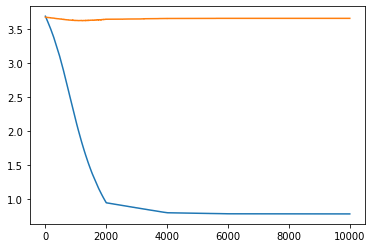

Text(0.5, 1.0, 'Peak Acc: 89.53%, Peak VAcc: 12.50%')

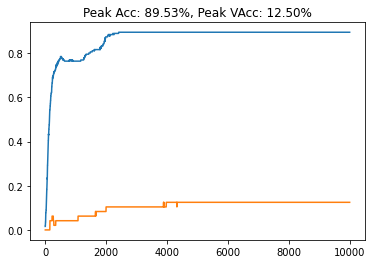

In [89]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("train_x_s.device:", train_x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    dropout=0.5).to(device)

print("y_s.shape[-1] original:", train_y_s.shape[-1])
epochs = 10000
lr = 1e-5

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []
criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
        model.train()
        
        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(test_loss)
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")

### Test Set Phoneme Distribution

In [322]:
print_phone_list(test_y_s)
#test_y_ph_lst = get_phone_list(test_y_phones.cpu())
## test_y_ph_lst = group_adjacent_duplicates(test_y_ph_lst)
#print(test_y_ph_lst)

['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'm', 'm', 'm', 'm', 'm', 'm', 'y', 'y', 'y', 'ah', 'ah', 'ah', 'n', 'n', 'n', 'n', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'z', 'ah', 'm', 'm', 'm', 'f', 'f', 'f', 'f', 'f', 'er', 'er', 'er', 'er', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil']


(72, 1)


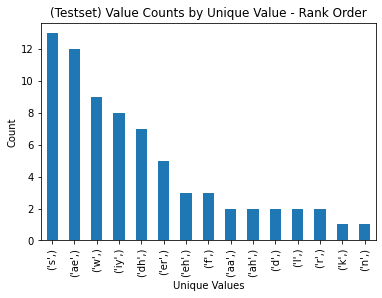

In [62]:
import matplotlib.pyplot as plt

test_y_df = pd.DataFrame(columns=["phoneme"], data=[dataset.phoneme_dict[d]
                                                    for d in test_y_phones.cpu()])

# get the value counts and sort them in descending order
counts = test_y_df.value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('(Testset) Value Counts by Unique Value - Rank Order')

# display the plot
print(test_y_df.shape)
plt.show()

### Phoneme Prediction Confusion Matrix

In [63]:
cm_pred = test_pred_phones.cpu()

In [64]:
cm_y = test_y_phones.cpu()

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cm_y, cm_pred)

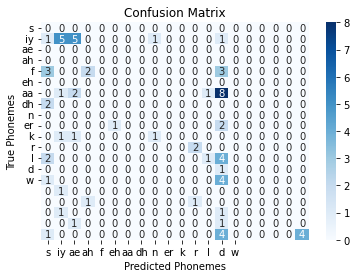

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

labels = np.unique(cm_y)

labels = [dataset.phoneme_dict[ph] for ph in labels]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set labels and title
plt.xlabel('Predicted Phonemes')
plt.ylabel('True Phonemes')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [67]:
cm

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 5, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0,

In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Extracting true negatives, false positives, false negatives, true positives
# tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

# Compute evaluation metrics
accuracy   = accuracy_score(cm_y, cm_pred)
precision  = precision_score(cm_y, cm_pred, average="micro")
recall     = recall_score(cm_y, cm_pred, average="micro")
f1         = f1_score(cm_y, cm_pred, average="micro")

# Print confusion matrix and evaluation metrics
print("Confusion Matrix:")
print(cm)
# print("True Negatives:", tn)
# print("False Positives:", fp)
# print("False Negatives:", fn)
# print("True Positives:", tp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 5 5 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 0 2 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0 0 0 1 8 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 4]]
Accuracy: 0.18055555555555555
Precision: 0.18055555555555555
Recall: 0.18055555555555555
F1 Score: 0.18055555555555555
